# Managing Risk: Studying Imbalanced Classes

#### Matthew Christian produced this Jupyter Notebook for the blog, analyticalmeandering.com

In [135]:
# Importing all the libraries we need

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from scipy.optimize import curve_fit

temp=345

In [29]:
# Loading data
loans = pd.read_csv('LoanStats_securev1_2020Q1.csv', header=1, low_memory=False)[:-4]
loans.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,desc,dti,delinq_2yrs,fico_range_low,...,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
count,0.0,105012.000000,105012.000000,105012.000000,105012.000000,1.050120e+05,0.0,104820.000000,105012.000000,105012.000000,...,10112.000000,12767.000000,12767.000000,12767.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,16829.695654,16829.695654,16826.721946,483.912041,8.862647e+04,NaN,21.604807,0.220099,706.530587,...,0.520965,515.073761,17083.024021,742.094555,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,10437.361056,10437.361056,10436.594800,294.033533,9.889935e+04,NaN,20.037309,0.724668,35.560917,...,2.635612,566.699380,10309.781244,2464.245621,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1000.000000,1000.000000,1000.000000,30.640000,0.000000e+00,NaN,0.000000,0.000000,660.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,8500.000000,8500.000000,8500.000000,261.530000,5.000000e+04,NaN,13.390000,0.000000,680.000000,...,0.000000,204.714675,9427.610000,238.860000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,15000.000000,15000.000000,15000.000000,411.085000,7.300000e+04,NaN,19.770000,0.000000,700.000000,...,0.000000,380.700000,15250.170000,411.720000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,24000.000000,24000.000000,24000.000000,654.970000,1.050000e+05,NaN,26.980000,0.000000,725.000000,...,0.000000,646.220000,24206.985000,673.420000,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,40000.000000,40000.000000,40000.000000,1671.880000,9.999999e+06,NaN,999.000000,19.000000,845.000000,...,34.000000,11581.820000,41910.490000,40270.980000,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
loans['loan_status']

0         Current
1         Current
2         Current
3          Issued
4         Current
           ...   
105007    Current
105008    Current
105009    Current
105010    Current
105011    Current
Name: loan_status, Length: 105012, dtype: object

In [31]:
loans.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105012 entries, 0 to 105011
Data columns (total 150 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          105012 non-null  object 
 1   member_id                                   0 non-null       float64
 2   loan_amnt                                   105012 non-null  float64
 3   funded_amnt                                 105012 non-null  float64
 4   funded_amnt_inv                             105012 non-null  float64
 5   term                                        105012 non-null  object 
 6   int_rate                                    105012 non-null  object 
 7   installment                                 105012 non-null  float64
 8   grade                                       105012 non-null  object 
 9   sub_grade                                   105012 non-null  object 


In [32]:
# ETL to clean up the data file
# We end up with more than 100 features for the model

loans_formatted = loans.copy()
bad_loan_terms = ['Charged Off', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']

for index, row in loans_formatted.iterrows():
    if row['loan_status'] in bad_loan_terms:
        loans_formatted.loc[index, 'loan_status'] = 1
    else:
        loans_formatted.loc[index, 'loan_status'] = 0

loans_formatted['loan_status'] = loans_formatted['loan_status'].astype('float64')

        
loans_formatted = loans_formatted.dropna(axis=1, how='all')

columns_to_drop = ['sub_grade', 'emp_title', 'pymnt_plan', 'url', 'zip_code', 'purpose', 'addr_state', 
                   'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d']
loans_formatted = loans_formatted.drop(columns_to_drop, axis=1)

loans_formatted['id'] = loans_formatted['id'].astype(float)
loans_formatted['term'] = loans_formatted['term'].str.extract('(\d+)').astype(float)
loans_formatted['int_rate'] = loans_formatted['int_rate'].str.extract('(\d+.\d+)').astype(float)/100
loans_formatted['emp_length'] = loans_formatted['emp_length'].str.extract('(\d+)').astype(float).fillna(0)
loans_formatted['issue_d'] = loans_formatted['issue_d'].str[:3]
loans_formatted['earliest_cr_line'] = loans_formatted['earliest_cr_line'].str[-2:].astype(float)
loans_formatted['revol_util'] = loans_formatted['revol_util'].str.extract('(\d+.\d+)').astype(float)/100

num_records = loans_formatted.shape[0]
for col in loans_formatted.columns:
    if (loans_formatted[col].notna().sum() < num_records/2):
        loans_formatted = loans_formatted.drop(col, axis=1)
    else:      
        if (loans_formatted[col].dtype != 'float64'):
            loans_formatted = pd.get_dummies(loans_formatted, columns=[col])
        elif (loans_formatted[col].isna().sum() != loans_formatted.shape[0]):
            loans_formatted[col] = loans_formatted[col].fillna(loans_formatted[col].mean())
loans_formatted

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,...,title_Moving and relocation,title_Other,title_Vacation,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y,debt_settlement_flag_N
0,166795268.0,5000.0,5000.0,5000.0,36.0,0.1862,182.33,0.0,36000.0,0.0,...,0,1,0,1,0,1,0,1,0,1
1,168699312.0,15000.0,15000.0,15000.0,60.0,0.1608,365.41,1.0,45000.0,0.0,...,0,0,0,0,1,1,0,1,0,1
2,167925465.0,4550.0,4550.0,4550.0,36.0,0.0756,141.66,1.0,53040.0,0.0,...,0,0,0,1,0,1,0,1,0,1
3,168689417.0,4000.0,4000.0,4000.0,36.0,0.1730,143.21,10.0,125000.0,0.0,...,0,0,0,0,1,1,0,0,1,1
4,168694393.0,15075.0,15075.0,15075.0,36.0,0.1081,492.19,10.0,73000.0,0.0,...,0,0,0,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105007,163119880.0,10525.0,10525.0,10525.0,36.0,0.0756,327.69,10.0,40000.0,0.0,...,0,0,1,0,1,1,0,1,0,1
105008,163267959.0,16000.0,16000.0,16000.0,36.0,0.1171,529.22,10.0,80000.0,0.0,...,0,0,0,0,1,1,0,1,0,1
105009,163221893.0,10000.0,10000.0,10000.0,36.0,0.1033,324.23,10.0,85000.0,0.0,...,0,0,0,0,1,1,0,0,1,1
105010,163197179.0,7500.0,7500.0,7500.0,60.0,0.0819,152.76,1.0,30000.0,0.0,...,0,0,0,0,1,1,0,1,0,1


In [33]:
loans_formatted.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105012 entries, 0 to 105011
Data columns (total 120 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   id                                   105012 non-null  float64
 1   loan_amnt                            105012 non-null  float64
 2   funded_amnt                          105012 non-null  float64
 3   funded_amnt_inv                      105012 non-null  float64
 4   term                                 105012 non-null  float64
 5   int_rate                             105012 non-null  float64
 6   installment                          105012 non-null  float64
 7   emp_length                           105012 non-null  float64
 8   annual_inc                           105012 non-null  float64
 9   loan_status                          105012 non-null  float64
 10  dti                                  105012 non-null  float64
 11  delinq_2yrs 

In [25]:
# This function runs the neural network to evaluate all accuracy metrics 

def run_model(x_train, x_test, y_train, y_test):

    print('Run number: {}'.format(index))
    print('______________')
    print(y_train.value_counts())

    scaler = StandardScaler()
    scaler = scaler.fit(x_train)
    standardized = scaler.transform(x_train)
    
    # This model leverages the MLPClassifier neural network
    mlp = MLPClassifier(hidden_layer_sizes=(10, 10), activation='logistic', max_iter=2000, random_state=42)
    mlp.fit(standardized, y_train)
    predictions = mlp.predict(scaler.transform(x_test))
    
    run_results = y_test.to_frame()
    run_results['Predictions'] = predictions
    
    actual_positives = run_results[run_results['loan_status']==1].shape[0]
    actual_negatives = run_results[run_results['loan_status']==0].shape[0]
    
    true_positives = run_results[(run_results['loan_status']==1) & (run_results['Predictions']==1)].shape[0]
    true_negatives = run_results[(run_results['loan_status']==0) & (run_results['Predictions']==0)].shape[0]
    
    false_positives = run_results[(run_results['loan_status']==0) & (run_results['Predictions']==1)].index
    false_negatives = run_results[(run_results['loan_status']==1) & (run_results['Predictions']==0)].index
    
    loss_opp_good_loan = x_test.loc[false_positives,'funded_amnt_inv'].multiply(
        x_test.loc[false_positives,'int_rate'].multiply(
            x_test.loc[false_positives,'term'])).sum()/12

    loss_bad_loan = x_test.loc[false_negatives,'funded_amnt_inv'].sum()    

    false_positives = run_results[(run_results['loan_status']==0) & (run_results['Predictions']==1)].shape[0]
    false_negatives = run_results[(run_results['loan_status']==1) & (run_results['Predictions']==0)].shape[0]
        
    accuracy = (true_positives+true_negatives)/(true_positives+true_negatives+false_positives+false_negatives)
    print('Overall accuracy is {:.1%}'.format(accuracy))
    
    recall = true_positives/(true_positives+false_negatives)
    print('Recall: Out of the {} positive (default) cases, {} ({:.1%}) were correctly predicted'.format
          (true_positives+false_negatives, true_positives, recall))
    
    try:                
        precision = true_positives/(true_positives+false_positives)
        print('Precision: Out of the {} positive (default) predictions, {} ({:.1%}) were actually positive'.format
          (true_positives+false_positives, true_positives, precision))
    except:
        print('No default predictions')
    
    print('Misclassifications cost ${:,.0f}'.format(loss_opp_good_loan+loss_bad_loan))
    print()
    return accuracy, recall, precision, true_positives+false_negatives

In [130]:
def show_graph(data, algo):

    plt.figure(figsize=(8, 4))
    plt.scatter(data['recall'], data['precision'], 
             c=data['minority_portion'], marker='o')
    cbar = fig.colorbar(im, format=cbar_num_format)
    cbar.ax.set_yticklabels(["{:.0%}".format(i) for i in cbar.get_ticks()])
    cbar.ax.set_ylabel('Minority Class Portion in Train Cases', rotation=270, labelpad=15)
    plt.title('Precision Recall Curves for {} Algorithm'.format(algo))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    file_name = algo+'.jpg'
    plt.savefig(file_name, dpi=300)
    plt.show()

In [131]:
# Base Case

loans_base = loans_formatted.copy()
x_train, x_test, y_train, y_test = train_test_split(loans_base.drop('loan_status', axis=1), 
                                                loans_base['loan_status'], test_size=0.2, random_state=42)

# The ratio of the principle of a bad loan to the profit of a good loan
expected_profit_good_loan = x_train.loc[y_train[y_train==0].index,'funded_amnt_inv'].multiply(
    x_train.loc[y_train[y_train==0].index,'int_rate'].multiply(
        x_train.loc[y_train[y_train==0].index,'term'])).mean()/12

print('The average profit for a good loan is ${:,.0f}'.format(expected_profit_good_loan))

expected_loss_bad_loan = x_train.loc[y_train[y_train==1].index,'funded_amnt_inv'].mean()
print('The average loss of principle for a bad loan is ${:,.0f}'.format(expected_loss_bad_loan))

ratio_of_losses = expected_loss_bad_loan/expected_profit_good_loan
print('The ratio of the average loss of principle for a bad loan to the expected lost opportunity cost', 
      'for a good loan is {:,.1f}'.format (ratio_of_losses))
print()

index = 'Base Case'
accuracy, recall, precision, pos_base_case = run_model(x_train, x_test, y_train, y_test)

The average profit for a good loan is $8,488
The average loss of principle for a bad loan is $17,151
The ratio of the average loss of principle for a bad loan to the expected lost opportunity cost for a good loan is 2.0

Run number: Base Case
______________
0.0    83220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 101 (47.0%) were correctly predicted
Precision: Out of the 145 positive (default) predictions, 101 (69.7%) were actually positive
Misclassifications cost $2,577,444



Run number: 0
______________
0.0    83220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 101 (47.0%) were correctly predicted
Precision: Out of the 145 positive (default) predictions, 101 (69.7%) were actually positive
Misclassifications cost $2,577,444

Run number: 1
______________
0.0    82220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.3%
Recall: Out of the 215 positive (default) cases, 109 (50.7%) were correctly predicted
Precision: Out of the 147 positive (default) predictions, 109 (74.1%) were actually positive
Misclassifications cost $2,344,682

Run number: 2
______________
0.0    81220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 109 (50.7%) were correctly predicted
Precision: Out of the 163 positive (default) predictions, 109 (66.9%) were actually positive
Misclassifications cost $2,555,583

Run number: 3
__

Run number: 25
______________
0.0    58220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.1%
Recall: Out of the 215 positive (default) cases, 109 (50.7%) were correctly predicted
Precision: Out of the 188 positive (default) predictions, 109 (58.0%) were actually positive
Misclassifications cost $2,740,644

Run number: 26
______________
0.0    57220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.3%
Recall: Out of the 215 positive (default) cases, 117 (54.4%) were correctly predicted
Precision: Out of the 174 positive (default) predictions, 117 (67.2%) were actually positive
Misclassifications cost $2,394,073

Run number: 27
______________
0.0    56220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.1%
Recall: Out of the 215 positive (default) cases, 113 (52.6%) were correctly predicted
Precision: Out of the 195 positive (default) predictions, 113 (57.9%) were actually positive
Misclassifications cost $2,651,548

Run number: 2

Run number: 50
______________
0.0    33220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 98.8%
Recall: Out of the 215 positive (default) cases, 121 (56.3%) were correctly predicted
Precision: Out of the 277 positive (default) predictions, 121 (43.7%) were actually positive
Misclassifications cost $3,171,240

Run number: 51
______________
0.0    32220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 98.9%
Recall: Out of the 215 positive (default) cases, 123 (57.2%) were correctly predicted
Precision: Out of the 272 positive (default) predictions, 123 (45.2%) were actually positive
Misclassifications cost $3,146,596

Run number: 52
______________
0.0    31220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 98.8%
Recall: Out of the 215 positive (default) cases, 131 (60.9%) were correctly predicted
Precision: Out of the 289 positive (default) predictions, 131 (45.3%) were actually positive
Misclassifications cost $3,061,635

Run number: 5

Run number: 75
______________
0.0    8220
1.0     789
Name: loan_status, dtype: int64
Overall accuracy is 97.0%
Recall: Out of the 215 positive (default) cases, 146 (67.9%) were correctly predicted
Precision: Out of the 717 positive (default) predictions, 146 (20.4%) were actually positive
Misclassifications cost $6,197,839

Run number: 76
______________
0.0    7220
1.0     789
Name: loan_status, dtype: int64
Overall accuracy is 97.0%
Recall: Out of the 215 positive (default) cases, 143 (66.5%) were correctly predicted
Precision: Out of the 710 positive (default) predictions, 143 (20.1%) were actually positive
Misclassifications cost $6,418,153

Run number: 77
______________
0.0    6220
1.0     789
Name: loan_status, dtype: int64
Overall accuracy is 96.6%
Recall: Out of the 215 positive (default) cases, 148 (68.8%) were correctly predicted
Precision: Out of the 795 positive (default) predictions, 148 (18.6%) were actually positive
Misclassifications cost $7,165,934

Run number: 78
____

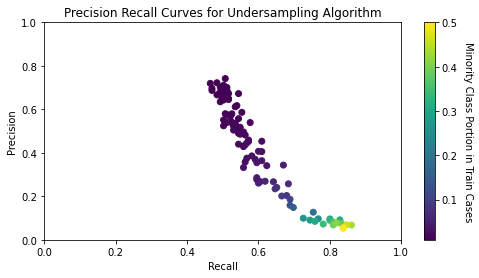

In [34]:
# Under sampling 
under_sampling = pd.DataFrame()

index = 0
for remove_n in list(range(0, 81000, 1000)) + list(range(81000, 82431, 100)) + list(range(82431, 82432)):
    
    loans_oversampled = loans_formatted.copy()
    
    x_train, x_test, y_train, y_test = train_test_split(loans_oversampled.drop('loan_status', axis=1), 
                                                        loans_oversampled['loan_status'], test_size=0.2, random_state=42)
    
    drop_indices = np.random.choice(y_train[y_train==0].index, remove_n, replace=False)
    x_train = x_train.drop(drop_indices)
    y_train = y_train.drop(drop_indices)
     
    accuracy, recall, precision, total_neg = run_model(x_train, x_test, y_train, y_test)
    
    under_sampling.loc[index, 'minority_portion'] = y_train[y_train==1].shape[0]/y_train.shape[0]
    under_sampling.loc[index, 'recall'] = recall
    under_sampling.loc[index, 'precision'] = precision
    under_sampling.loc[index, 'Accuracy'] = accuracy
    
    index+=1

show_graph(data=under_sampling, algo='Undersampling')

under_sampling.to_csv('under_sampling.csv')

Run number: 0
______________
0.0    83220
1.0      789
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 101 (47.0%) were correctly predicted
Precision: Out of the 145 positive (default) predictions, 101 (69.7%) were actually positive
Misclassifications cost $2,577,444

Run number: 1
______________
0.0    83220
1.0     2789
Name: loan_status, dtype: int64
Overall accuracy is 98.8%
Recall: Out of the 215 positive (default) cases, 117 (54.4%) were correctly predicted
Precision: Out of the 263 positive (default) predictions, 117 (44.5%) were actually positive
Misclassifications cost $3,152,087

Run number: 2
______________
0.0    83220
1.0     4789
Name: loan_status, dtype: int64
Overall accuracy is 98.8%
Recall: Out of the 215 positive (default) cases, 123 (57.2%) were correctly predicted
Precision: Out of the 282 positive (default) predictions, 123 (43.6%) were actually positive
Misclassifications cost $3,009,010

Run number: 3
__

Run number: 25
______________
0.0    83220
1.0    50789
Name: loan_status, dtype: int64
Overall accuracy is 97.9%
Recall: Out of the 215 positive (default) cases, 121 (56.3%) were correctly predicted
Precision: Out of the 458 positive (default) predictions, 121 (26.4%) were actually positive
Misclassifications cost $4,554,409

Run number: 26
______________
0.0    83220
1.0    52789
Name: loan_status, dtype: int64
Overall accuracy is 98.2%
Recall: Out of the 215 positive (default) cases, 127 (59.1%) were correctly predicted
Precision: Out of the 422 positive (default) predictions, 127 (30.1%) were actually positive
Misclassifications cost $4,378,858

Run number: 27
______________
0.0    83220
1.0    54789
Name: loan_status, dtype: int64
Overall accuracy is 98.2%
Recall: Out of the 215 positive (default) cases, 120 (55.8%) were correctly predicted
Precision: Out of the 405 positive (default) predictions, 120 (29.6%) were actually positive
Misclassifications cost $4,468,073

Run number: 2

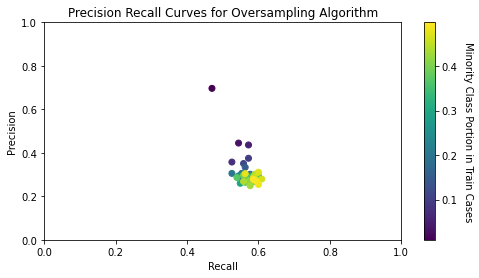

In [24]:
# Over sampling 

over_sampling = pd.DataFrame()

index = 0
for add_n in range(0, 82500, 2000):

    loans_oversampled = loans_formatted.copy()
    
    x_train, x_test, y_train, y_test = train_test_split(loans_oversampled.drop('loan_status', axis=1), 
                                                        loans_oversampled['loan_status'], test_size=0.2, random_state=42)    
    
    add_indices = y_train[y_train == 1].sample(n=add_n, replace=True, random_state=42).index
    x_train = x_train.append(x_train.loc[add_indices], ignore_index=True)
    y_train = y_train.append(y_train.loc[add_indices], ignore_index=True)
    
    accuracy, recall, precision, total_neg = run_model(x_train, x_test, y_train, y_test)
    
    over_sampling.loc[index,'minority_portion'] = y_train[y_train==1].shape[0]/y_train.shape[0]
    over_sampling.loc[index,'recall'] = recall
    over_sampling.loc[index,'precision'] = precision
    over_sampling.loc[index,'Accuracy'] = accuracy
    
    index+=1

show_graph(data=over_sampling, algo='Oversampling')
over_sampling.to_csv('over_sampling.csv')

Run number: 0
______________
0.0    83220
1.0     1664
Name: loan_status, dtype: int64
Overall accuracy is 99.3%
Recall: Out of the 215 positive (default) cases, 103 (47.9%) were correctly predicted
Precision: Out of the 136 positive (default) predictions, 103 (75.7%) were actually positive
Misclassifications cost $2,307,502

Run number: 1
______________
0.0    83220
1.0     3328
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 102 (47.4%) were correctly predicted
Precision: Out of the 159 positive (default) predictions, 102 (64.2%) were actually positive
Misclassifications cost $2,698,748

Run number: 2
______________
0.0    83220
1.0     4993
Name: loan_status, dtype: int64
Overall accuracy is 99.3%
Recall: Out of the 215 positive (default) cases, 101 (47.0%) were correctly predicted
Precision: Out of the 137 positive (default) predictions, 101 (73.7%) were actually positive
Misclassifications cost $2,396,517

Run number: 3
__

Run number: 25
______________
0.0    83220
1.0    43274
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 98 (45.6%) were correctly predicted
Precision: Out of the 144 positive (default) predictions, 98 (68.1%) were actually positive
Misclassifications cost $2,545,685

Run number: 26
______________
0.0    83220
1.0    44938
Name: loan_status, dtype: int64
Overall accuracy is 99.2%
Recall: Out of the 215 positive (default) cases, 105 (48.8%) were correctly predicted
Precision: Out of the 158 positive (default) predictions, 105 (66.5%) were actually positive
Misclassifications cost $2,499,373

Run number: 27
______________
0.0    83220
1.0    46603
Name: loan_status, dtype: int64
Overall accuracy is 99.3%
Recall: Out of the 215 positive (default) cases, 105 (48.8%) were correctly predicted
Precision: Out of the 140 positive (default) predictions, 105 (75.0%) were actually positive
Misclassifications cost $2,370,661

Run number: 28


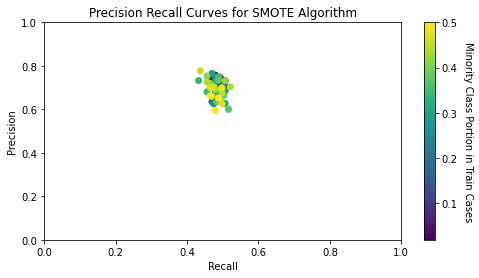

In [35]:
# SMOTE

smote_sampling = pd.DataFrame()

index = 0
for ratio in range(2, 101, 2):

    loans_oversampled = loans_formatted.copy()

    x_train, x_test, y_train, y_test = train_test_split(loans_oversampled.drop('loan_status', axis=1), 
                                                        loans_oversampled['loan_status'], test_size=0.2, random_state=42)
    
    sm = SMOTE(sampling_strategy=ratio/100, random_state=42)
    x_train, y_train = sm.fit_resample(x_train, y_train)
       
    accuracy, recall, precision, total_neg = run_model(x_train, x_test, y_train, y_test)
    
    smote_sampling.loc[index,'minority_portion'] = y_train[y_train==1].shape[0]/y_train.shape[0]
    smote_sampling.loc[index,'recall'] = recall
    smote_sampling.loc[index,'precision'] = precision
    smote_sampling.loc[index,'Accuracy'] = accuracy
    
    index+=1

show_graph(data=smote_sampling, algo='SMOTE')
smote_sampling.to_csv('smote_sampling.csv')

In [133]:
under_sampling = pd.read_csv('under_sampling.csv')
over_sampling = pd.read_csv('over_sampling.csv')
smote_sampling = pd.read_csv('smote_sampling.csv')

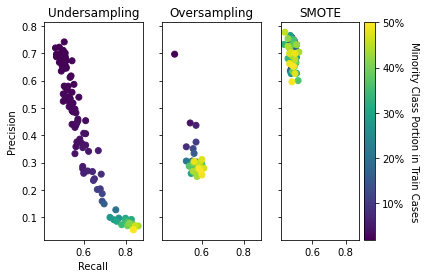

In [132]:
temp += 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

ax1.scatter(under_sampling['recall'], under_sampling['precision'], c=under_sampling['minority_portion'], marker='o')
ax2.scatter(over_sampling['recall'], over_sampling['precision'], c=over_sampling['minority_portion'], marker='o')
ax3.scatter(smote_sampling['recall'], smote_sampling['precision'], c=smote_sampling['minority_portion'], marker='o')

ax1.set_title('Undersampling')
ax2.set_title('Oversampling')
ax3.set_title('SMOTE')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')

im = plt.gca().get_children()[0]
cbar_num_format = '%.1f'

cbar = fig.colorbar(im, format=cbar_num_format)
cbar.ax.set_yticklabels(["{:.0%}".format(i) for i in cbar.get_ticks()])
cbar.ax.set_ylabel('Minority Class Portion in Train Cases', rotation=270, labelpad=15)

file_name = str(temp)+'.jpg'
plt.savefig(file_name, dpi=300)

plt.show()

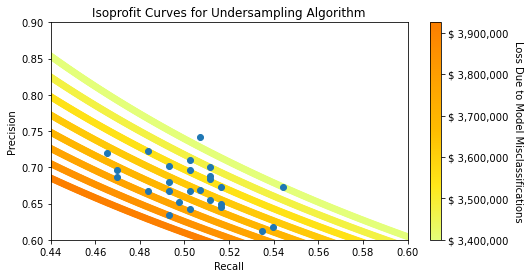

In [134]:
plt.figure(figsize=(8, 4))
graph_data = pd.DataFrame(columns=['Recall', 'Precision', 'Loss'])
precision = np.arange(0.44, 0.9, 0.001)

for loss in range(3400000, 4000000, 75000):
    temp_data = pd.DataFrame()
    temp_data['Precision'] = precision
    temp_data['Recall'] = (-loss/pos_base_case + expected_loss_bad_loan + expected_profit_good_loan/precision
                          )/(expected_profit_good_loan + expected_loss_bad_loan)
    temp_data['Loss'] = loss   
    graph_data = graph_data.append(temp_data)
        
plot_subset = under_sampling[under_sampling['recall'].between(0, 1)].copy() 
plt.scatter(plot_subset['recall'], plot_subset['precision'], marker='o', zorder=1)
scatter=plt.scatter(graph_data['Recall'], graph_data['Precision'], c=graph_data['Loss'], marker='o', cmap='Wistia', zorder=0)
cb = plt.colorbar(scatter)
cb.ax.set_yticklabels(["$ {:,.0f}".format(i) for i in cb.get_ticks()])
cb.ax.set_ylabel('Loss Due to Model Misclassifications', rotation=270, labelpad=15)
plt.title('Isoprofit Curves for Undersampling Algorithm')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0.44, 0.60)
plt.ylim(0.6, 0.9)
plt.savefig('indifference.jpg', dpi=300)
plt.show()